## A - Importing Libraries

In [1]:
!pip install gymnasium tensorflow tensorflow-metal matplotlib ale-py "numpy==1.23.5"

In [2]:
import gymnasium as gym
import random
import numpy as np
from matplotlib import style
from  matplotlib import pylab
from collections import deque
import matplotlib.pyplot as plt
import ale_py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
%matplotlib inline

/Users/harvardyearbook/Downloads/neuro140/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Plot configuration

In [3]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,6)
load_model = False 

gym.register_envs(ale_py)

## B - Creating Agent Class

    All classes that needs to be created are created in one class.

In [7]:
class Agent():
    def __init__(self, epsilon_decay, epsilon_min, 
                       gamma, learning_rate, state_size, action_size,
                       batch_size, training_threshold):
        '''CREATING AND DEFINING BASIC PARAMETERS FOR TRAINING'''
        self.movement_penalty = -1 
        # Change epsilon if model is already trained.
        self.epsilon = 1                                                                  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min                
        self.gamma = gamma
        self.learning_rate = learning_rate

        self.state_size = state_size
        self.action_size = action_size
        
        self.batch_size = batch_size
        self.training_threshold = training_threshold

         # Main Model
        self.model = self.create_model()
        
         # Target Model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
 
        self.target_update_counter = 0

        # Replay Memory
        self.replay_memory = deque(maxlen=2000) 

        if load_model:
            try:
                # Make sure the path is correct and matches the new model architecture
                self.model.load_weights("././Deep Q-Learning - PACMAN/final_version_v2.weights.h5") # Use a new file name
                self.target_model.set_weights(self.model.get_weights()) # Sync target model on load
                print("Model weights loaded successfully.")
            except Exception as e:
                print(f"Error loading model weights: {e}. Starting from scratch.")   
                
        
    
    def update_replay_memory(self, state, action, reward, next_state, done):
        '''UPDATING REPLAY MEMORY and DECAYIN EPSILON'''
        self.replay_memory.append((state, action, reward, next_state, done))

        if self.epsilon > self.epsilon_min:                                                       
            self.epsilon *= self.epsilon_decay       
    

    def create_model(self):
        '''CREATING NEURAL NETWORK'''
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss = "mse")          
        return model
    

    def select_action(self, state):
        '''DEFINING EPSILON GREEDY STRATEGY'''
        if np.random.rand() > self.epsilon:
            q_value = self.model.predict(state, verbose=0)
            return np.argmax(q_value[0])
        else:
            return np.random.randint(0, self.action_size)             
 

    def train_agent(self):
        '''TRAINING AGENT'''
        if len(self.replay_memory) < self.training_threshold:
                  return
        
        batch_size = min(self.batch_size, len(self.replay_memory))
        minibatch = random.sample(self.replay_memory, batch_size)
 
        observations = np.zeros((batch_size, self.state_size))                    
        next_observations = np.zeros((batch_size, self.state_size))
        
        action = []
        reward = [] 
        done = []
        
        for sample_index in range(self.batch_size):
            observations[sample_index] = minibatch[sample_index][0]                       
            action.append(minibatch[sample_index][1])
            reward.append(minibatch[sample_index][2])
            next_observations[sample_index] = minibatch[sample_index][3]
            done.append(minibatch[sample_index][4])

            
        current_q_values = self.model.predict(observations, verbose=0)
        future_q_values = self.target_model.predict(next_observations, verbose=0)
    
        for index in range(self.batch_size):
            if not done[index]:    
                current_q_values[index][action[index]] = reward[index] + self.gamma * (np.amax(future_q_values[index]))
            else:
                current_q_values[index][action[index]] = reward[index]            

        self.model.fit(observations, current_q_values, batch_size = batch_size, verbose=0)                              
        
        if done:
            self.target_update_counter += 1
        
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

## C - Setting Hyperparameters

In [5]:
num_episodes= 2100                          
epsilon_decay = 0.999998                   
epsilon_min = 0.1                 
gamma = 0.99
learning_rate = 0.000001        
batch_size = 64
training_threshold = 1000 
update_target_every = 10
load_model = True                      

## D - Training Agent

Error loading model weights: [Errno 2] Unable to synchronously open file (unable to open file: name = '././Deep Q-Learning - PACMAN/final_version_v2.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Starting from scratch.
Episode: 0 -----Score: 220.0 -----Epsilon: 0.9991303774710528
Saved model to disk


2025-04-04 15:51:52.844500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Episode: 1 -----Score: 280.0 -----Epsilon: 0.9981736679497808
Episode: 2 -----Score: 340.0 -----Epsilon: 0.996990534533288
Episode: 3 -----Score: 420.0 -----Epsilon: 0.9957769380789361
Episode: 4 -----Score: 340.0 -----Epsilon: 0.9946603017879068
Episode: 5 -----Score: 220.0 -----Epsilon: 0.9936164555423929
Episode: 6 -----Score: 240.0 -----Epsilon: 0.99253400256747
Episode: 7 -----Score: 270.0 -----Epsilon: 0.9916153405686043
Episode: 8 -----Score: 180.0 -----Epsilon: 0.9906262011322813
Episode: 9 -----Score: 260.0 -----Epsilon: 0.9896063804231473
Episode: 10 -----Score: 250.0 -----Epsilon: 0.9886231994197616
Episode: 11 -----Score: 140.0 -----Epsilon: 0.987783225899623
Episode: 12 -----Score: 200.0 -----Epsilon: 0.986896593833536
Episode: 13 -----Score: 180.0 -----Epsilon: 0.9861843109455883
Episode: 14 -----Score: 370.0 -----Epsilon: 0.9849641689722445
Episode: 15 -----Score: 220.0 -----Epsilon: 0.9840643221146397
Episode: 16 -----Score: 190.0 -----Epsilon: 0.9831456342131566
Episod

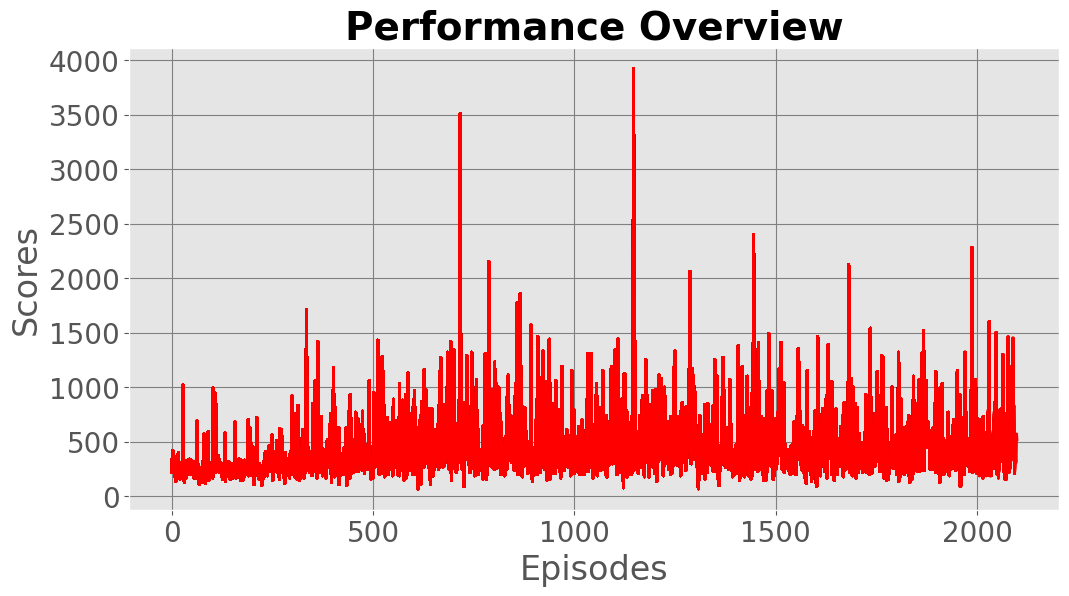

In [8]:
if __name__ == '__main__':
    with tf.device('/device:GPU:0'):
        
        env = gym.make('ALE/MsPacman-ram-v5')
        env.reset() 
        action_size = env.action_space.n
        state_size = env.observation_space.shape[0]
        agent = Agent(epsilon_decay, epsilon_min, 
                      gamma, learning_rate, state_size, 
                      action_size, batch_size, training_threshold)

        scores = []
        eps_plot = []
        episodes = []
        rewards_lst = []

        for episode in range(num_episodes):
            done = False
            score = 0
            state = env.reset()
            state = np.reshape(state[0], [1, state_size])                                      
            lives = 3
            while not done:
                dead = False
                while not dead:
                    # env.render()
                    action = agent.select_action(state)
                    
                    next_state, reward, done, truncated, info = env.step(action)                       
                    next_state = np.reshape(next_state, [1, state_size])                    
                    
                    agent.update_replay_memory(state, action, reward, next_state, done)
                    agent.train_agent()
                    
                    state = next_state
                    score += reward
                    dead = info['lives']<lives
                    lives = info['lives']
                    
                    if dead:
                        reward = -100
                    else:
                        if reward ==0:
                            reward = agent.movement_penalty
                        else:
                            reward = reward
                            
                if done:
                    scores.append(score)
                    episodes.append(episode)
                    pylab.plot(episodes, scores, 'red', linewidth=2)
                    plt.xlabel("Episodes",size=24)
                    plt.ylabel("Scores",size=24)
                    plt.xticks(size=20)
                    plt.yticks(size=20)
                    pylab.title("Performance Overview",size=28,fontweight="bold")
                    plt.grid(True,color="gray")
                    pylab.savefig("final_version_v2.png")
                    
                    print("Episode:", episode, "-----Score:", score,"-----Epsilon:", agent.epsilon)

            if (episode % 25 == 0):
                agent.model.save_weights("./Deep Q-Learning - PACMAN/final_version_v2.weights.h5")
                print("Saved model to disk")

In [13]:
scores

[200.0,
 260.0,
 190.0,
 160.0,
 230.0,
 170.0,
 280.0,
 180.0,
 300.0,
 260.0,
 280.0,
 110.0,
 210.0,
 180.0,
 440.0,
 350.0,
 250.0,
 730.0,
 290.0,
 350.0,
 290.0,
 230.0,
 220.0,
 260.0,
 450.0,
 210.0,
 300.0,
 260.0,
 420.0,
 340.0,
 200.0,
 210.0,
 520.0,
 230.0,
 190.0,
 380.0,
 220.0,
 220.0,
 200.0,
 260.0,
 250.0,
 210.0,
 210.0,
 140.0,
 220.0,
 190.0,
 260.0,
 170.0,
 210.0,
 280.0,
 150.0,
 190.0,
 320.0,
 180.0,
 220.0,
 210.0,
 300.0,
 210.0,
 200.0,
 230.0,
 210.0,
 180.0,
 140.0,
 260.0,
 620.0,
 290.0,
 230.0,
 320.0,
 280.0,
 180.0,
 220.0,
 210.0,
 250.0,
 180.0,
 320.0,
 210.0,
 240.0,
 210.0,
 230.0,
 170.0,
 380.0,
 330.0,
 200.0,
 240.0,
 150.0,
 280.0,
 280.0,
 170.0,
 250.0,
 240.0,
 250.0,
 190.0,
 260.0,
 200.0,
 180.0,
 280.0,
 240.0,
 890.0,
 270.0,
 290.0,
 250.0,
 170.0,
 180.0,
 280.0,
 730.0,
 220.0,
 290.0,
 220.0,
 160.0,
 210.0,
 150.0,
 240.0,
 180.0,
 310.0,
 250.0,
 240.0,
 260.0,
 290.0,
 220.0,
 240.0,
 170.0,
 310.0,
 360.0,
 190.0,
 290.0,


In [9]:
for i in scores:
    print(i)

220.0
280.0
340.0
420.0
340.0
220.0
240.0
270.0
180.0
260.0
250.0
140.0
200.0
180.0
370.0
220.0
190.0
400.0
220.0
210.0
200.0
160.0
250.0
310.0
240.0
210.0
190.0
180.0
1020.0
920.0
310.0
170.0
130.0
310.0
250.0
300.0
170.0
320.0
210.0
330.0
230.0
230.0
320.0
200.0
200.0
340.0
300.0
240.0
220.0
200.0
330.0
250.0
230.0
220.0
260.0
290.0
170.0
230.0
310.0
320.0
230.0
170.0
180.0
690.0
250.0
190.0
290.0
250.0
180.0
110.0
190.0
260.0
230.0
170.0
200.0
200.0
270.0
270.0
130.0
320.0
570.0
210.0
260.0
360.0
120.0
230.0
240.0
250.0
150.0
200.0
160.0
590.0
320.0
150.0
230.0
240.0
170.0
250.0
270.0
260.0
250.0
280.0
170.0
990.0
400.0
250.0
340.0
950.0
410.0
320.0
220.0
840.0
240.0
320.0
330.0
300.0
370.0
250.0
340.0
220.0
280.0
240.0
310.0
260.0
280.0
180.0
220.0
160.0
240.0
240.0
280.0
200.0
230.0
580.0
140.0
290.0
190.0
190.0
290.0
280.0
260.0
240.0
320.0
260.0
270.0
160.0
160.0
260.0
280.0
210.0
210.0
300.0
170.0
290.0
190.0
200.0
300.0
250.0
680.0
170.0
330.0
260.0
190.0
230.0
270.0
180.0
250